# Partial Differential Equations solved using PINNs.


### 1. Defining a few functions and initial, boundaries, eqns and stuff.
- dQ_dt + Q * dQ_dx = v * d2Q_dv2
- ic : Q(x, t=0) = sin(k * X)
- bc : Q(x=0, t) = Q(x=L, t)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import torch
import torch.nn as nn

### 1. Defining the initial arrays of space and time.

In [2]:
L = 1.0 #[m]
T_final = 1.0 #[s]
k = (2 * np.pi) / L

Nx = 50
Nt = 50


x = torch.linspace(-1, 1, Nx).view(-1, 1)  #[Nx]
t = torch.linspace(0, T_final, Nt).view(-1, 1) #[Nt]

print(f"Shape of x : {x.shape} and t : {t.shape}")

Shape of x : torch.Size([50, 1]) and t : torch.Size([50, 1])


In [3]:
# Meshes and vectors
X_train, t_train = torch.meshgrid(x.squeeze(), t.squeeze(), indexing='xy')

X_train, t_train = X_train.reshape(-1, 1), t_train.reshape(-1, 1)

print(f"Shape of X_train : {X_train.shape} and t_train : {t_train.shape}")

Shape of X_train : torch.Size([2500, 1]) and t_train : torch.Size([2500, 1])


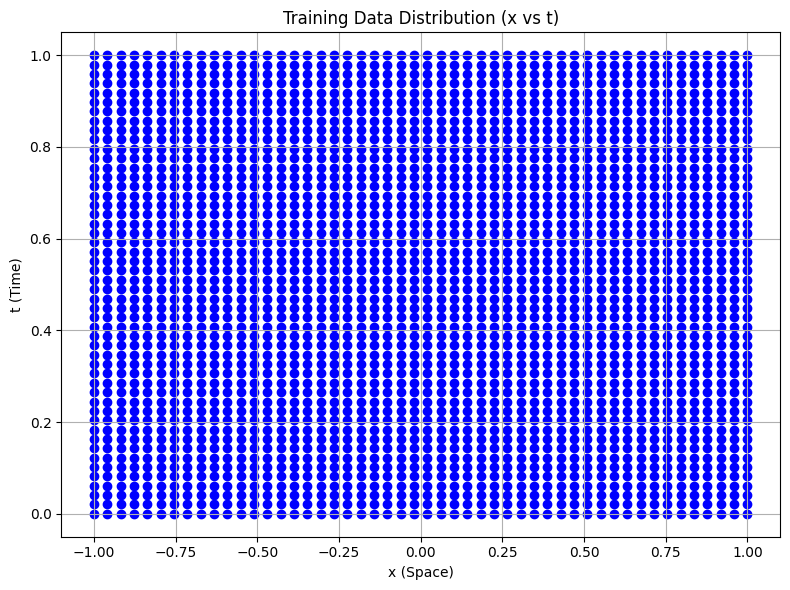

In [4]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train, t_train, c='blue')

plt.xlabel('x (Space)')
plt.ylabel('t (Time)')
plt.title('Training Data Distribution (x vs t)')
plt.grid(True)
plt.tight_layout()
plt.show()

### 2. Neural network architecture.

In [5]:
class PINN(nn.Module):
  def __init__(self, N_INPUT, N_HIDDEN, N_LAYERS, N_OUTPUT):
    super().__init__()
    activation = nn.Tanh

    layers = [nn.Linear(N_INPUT, N_HIDDEN), activation()] #initialy contains just the 1 layer

    for _ in range(N_LAYERS-1):
      layers.append(nn.Linear(N_HIDDEN, N_HIDDEN)) #adding n-1 layers and n-1 activation functions as well.
      layers.append(activation())

    layers.append(nn.Linear(N_HIDDEN, N_OUTPUT)) #final output layer

    self.net = nn.Sequential(*layers) #unpacking all contents of layers into sequential.

  def forward(self, x, t):
    inputs = torch.cat([x, t], dim=1)
    q = self.net(inputs)
    return q

### 3. Now defining the losses :
- The P.D.E loss
- The initial condition loss
- The boundary condition loss

In [6]:
def pde_loss(q_pred, x_train, t_train, nu = 0.01):
  """
  Eqn : dQ_dt + (Q * dQ_dx) = v * d2Q_dx2 [Okay we did this]

  IC : Q(x, t=0) = sin(k * x)
  BC : Q(x=-1, t) = Q(x=1, t) = 0  #Periodic Boundaries
  BC : Q(x, v=-1, t) = Q(x, v=1, t)

  Finds physics loss based on the above equation.
  """
  dQ_dt = torch.autograd.grad(q_pred, t_train, torch.ones_like(q_pred), create_graph=True)[0]
  dQ_dx = torch.autograd.grad(q_pred, x_train, torch.ones_like(q_pred), create_graph=True)[0]
  d2Q_dx2 = torch.autograd.grad(dQ_dx, x_train, torch.ones_like(dQ_dx), create_graph=True)[0]

  eqn = dQ_dt + (q_pred * dQ_dx) - ((nu/np.pi) * d2Q_dx2)

  return torch.mean(eqn**2)


def initial_condition_loss(q_pred, x, t):
  initial_condition = - torch.sin(np.pi * x)

  return torch.mean((q_pred-initial_condition) ** 2)


def boundary_condition_loss(qlb_pred, qup_pred, t):
  lb, ub = torch.zeros_like(t), torch.zeros_like(t)
  return torch.mean((qlb_pred-lb) ** 2) + torch.mean((qup_pred-ub) ** 2) # Periodic along x axis and v axis.


### 4. Writing the training loop.

In [7]:
model = PINN(2, 64, 5, 1)
optimiser = torch.optim.Adam(model.parameters(), lr = 0.001)
epochs = 1000

In [8]:
X_train.requires_grad = True
t_train.requires_grad = True

In [9]:
TOTAL_LOSS = []

for epoch in range(1, epochs+1):
  model.train()
  optimiser.zero_grad()

  # Initial Condition
  q_pred_init = model(x, torch.zeros_like(x)) # q(x, 0)
  ic_loss = initial_condition_loss(q_pred_init, x, torch.zeros_like(x))

  # Boundary Condition
  q_lb_pred = model(torch.full_like(t, -1), t) # q(-1, t)
  q_ub_pred = model(torch.full_like(t, 1), t) # q(1, t)
  bc_loss = boundary_condition_loss(q_lb_pred, q_ub_pred, t)

  # Physics Condition
  q_pred = model(X_train, t_train)
  physics_loss = pde_loss(q_pred, X_train, t_train)

  total_loss = physics_loss + ic_loss + bc_loss
  TOTAL_LOSS.append(total_loss.item())

  total_loss.backward()
  optimiser.step()

  if(epoch%1==0):
    print(f"[{epoch}/{epochs}] Losses - Total:{total_loss.item():.4f}, Physics:{physics_loss.item():.4f}, IC:{ic_loss.item():.4f}, BC:{bc_loss.item():.4f}")

[1/1000] Losses - Total:0.4887, Physics:0.0001, IC:0.4881, BC:0.0005
[2/1000] Losses - Total:0.4667, Physics:0.0000, IC:0.4627, BC:0.0040
[3/1000] Losses - Total:0.4517, Physics:0.0001, IC:0.4379, BC:0.0138
[4/1000] Losses - Total:0.4439, Physics:0.0003, IC:0.4120, BC:0.0316
[5/1000] Losses - Total:0.4446, Physics:0.0008, IC:0.3872, BC:0.0565
[6/1000] Losses - Total:0.4480, Physics:0.0013, IC:0.3737, BC:0.0730
[7/1000] Losses - Total:0.4467, Physics:0.0015, IC:0.3735, BC:0.0717
[8/1000] Losses - Total:0.4426, Physics:0.0014, IC:0.3811, BC:0.0600
[9/1000] Losses - Total:0.4392, Physics:0.0012, IC:0.3921, BC:0.0459
[10/1000] Losses - Total:0.4382, Physics:0.0010, IC:0.4031, BC:0.0340
[11/1000] Losses - Total:0.4387, Physics:0.0008, IC:0.4115, BC:0.0264
[12/1000] Losses - Total:0.4390, Physics:0.0008, IC:0.4155, BC:0.0228
[13/1000] Losses - Total:0.4380, Physics:0.0008, IC:0.4147, BC:0.0226
[14/1000] Losses - Total:0.4358, Physics:0.0009, IC:0.4095, BC:0.0254
[15/1000] Losses - Total:0.43

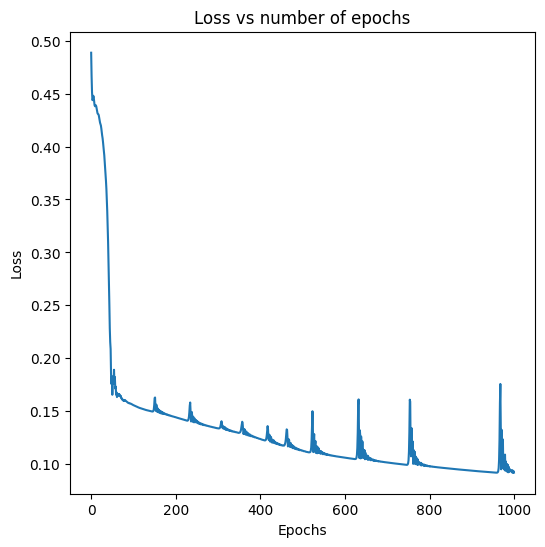

In [10]:
plt.figure(figsize=(6,6))
plt.plot(TOTAL_LOSS)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs number of epochs')

plt.savefig('Burgers_EpochLoss.png', dpi=300, bbox_inches='tight')

plt.show()

### 5. Testing the neural network.

In [11]:
N_test = 25

X_test = torch.linspace(-1, 1, N_test).view(-1, 1)
t_test = torch.linspace(0, 1, N_test).view(-1, 1)

X_test, t_test = torch.meshgrid(X_test.squeeze(),  t_test.squeeze(), indexing='xy')

X_test = X_test.reshape(-1, 1)
t_test = t_test.reshape(-1, 1)
print(f"Shape of X_test : {X_test.shape} and t_test : {t_test.shape}")

Shape of X_test : torch.Size([625, 1]) and t_test : torch.Size([625, 1])


In [12]:
model.eval()
with torch.no_grad():
  q_pred = model(X_test, t_test)

In [13]:
q_pred = q_pred.numpy()
X_test = X_test.numpy()
t_test = t_test.numpy()

q_pred = q_pred.reshape(N_test, N_test)
X_test = X_test.reshape(N_test, N_test)
t_test = t_test.reshape(N_test, N_test)

In [14]:
print(f"Shape of q_pred, x_test, t_test is {q_pred.shape}, {X_test.shape}, and {t_test.shape}")

Shape of q_pred, x_test, t_test is (25, 25), (25, 25), and (25, 25)


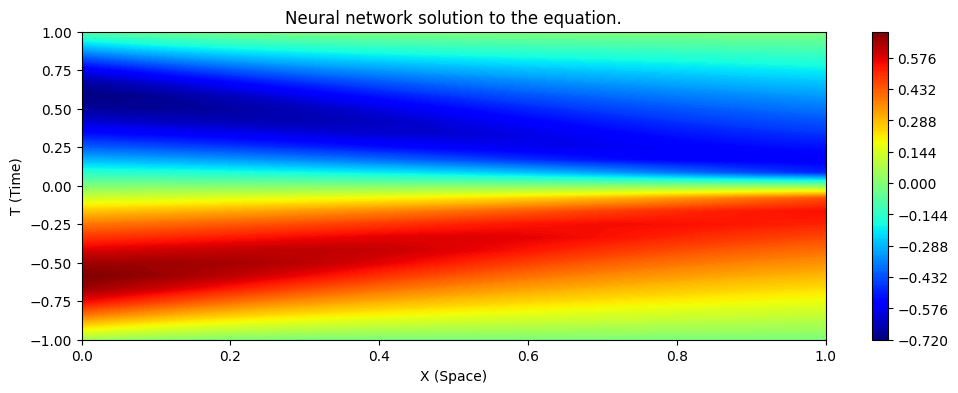

In [15]:
plt.figure(figsize=(12, 4))

plt.contourf(t_test, X_test, q_pred, levels=250, cmap='jet')
plt.colorbar()
plt.xlabel('X (Space)')
plt.ylabel('T (Time)')
plt.title('Neural network solution to the equation.')

plt.savefig('Burgers_2DPlot.png', dpi=300, bbox_inches='tight')

plt.show()